# Projet Phase 3 : Classification des puits d‚Äôeau en Tanzanie

## Contexte
La Tanzanie, pays en d√©veloppement, peine √† fournir de l'eau potable √† sa population de plus de 57 millions d'habitants. 
De nombreux points d'eau ont d√©j√† √©t√© install√©s, mais certains n√©cessitent des r√©parations tandis que d'autres sont totalement hors service.

## Objectif
L'objectif de ce projet est de cr√©er un **classificateur capable de pr√©dire l'√©tat d'un puits d'eau** (`status_group`) en utilisant des informations telles que :
- Type de pompe
- Date d‚Äôinstallation
- Localisation GPS
- Funder et Installer
- Qualit√© de l‚Äôeau et population desservie

Ce classificateur pourra √™tre utilis√© par :
- Une ONG souhaitant localiser rapidement les puits n√©cessitant des r√©parations
- Le gouvernement tanzanien pour identifier les tendances des puits non fonctionnels et optimiser la construction de nouveaux puits

## Approche ML
- Nous commencerons par une **classification ternaire** (fonctionnel / √† r√©parer / hors service), avec la possibilit√© de transformer le probl√®me en **binaire** pour simplifier la d√©tection des puits √† risque.
- Le notebook est structur√© en plusieurs √©tapes : **EDA, nettoyage et pr√©paration des donn√©es, mod√©lisation ML, √©valuation et insights op√©rationnels**.

## Impact attendu
Les r√©sultats permettront d‚Äôorienter les d√©cisions strat√©giques pour la maintenance et la construction de nouveaux puits d‚Äôeau, optimisant ainsi l‚Äôacc√®s √† l‚Äôeau potable pour la population.


In [1]:
# Importation des biblioth√®ques
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss
from math import sqrt

sns.set_style("whitegrid")
%matplotlib inline

## Chargement du dataset

In [2]:
# Chargement du jeu de donn√©es
df1 = pd.read_csv("C:/Users/Saint Germain Emode/Downloads/Data/Tanz_train_values.csv")
df2 = pd.read_csv("C:/Users/Saint Germain Emode/Downloads/Data/Tanz_train_labels.csv")

# Dimensions du dataset
print("df1 :", df1.shape)
print("df2 :", df2.shape)

df1 : (59400, 40)
df2 : (59400, 2)


In [3]:
# Fusionner les datasets
df_merge = pd.merge(df1, df2, on="id", how="inner")
df_merge.shape

(59400, 41)

In [4]:
# Dimensions du dataset
print("Dimensions du dataset fusionn√© :", df_merge.shape)

# Informations g√©n√©rales
df_merge.info()

df_merge.isnull().sum()

Dimensions du dataset fusionn√© : (59400, 41)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [5]:
# Aper√ßu des premi√®res lignes
df_merge.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... water_quality  \
0  34.938093  -9.856322                  none            0  ...          soft   
1  34.698766  -2.147466              Zahanati            0  ...          soft   
2  37.460664  -3.821329           Kwa Mahundi            0  ...          soft   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...          soft   
4  31.130847  -1.825359               Shuleni            0  ...          soft   

  quality_group      quantity  quantity_group                source  \
0          good        enough          enough                spring   
1          good  insufficient    insufficient  rainwater harvesting   
2          good        enough          enough                   dam   
3          good           dry             dry           machine dbh   
4          good      seasonal        seasonal  rainwater harvesting   

            source_type source_class              waterpoint_type  \
0                spring  groundwater           communal standpipe   
1  rainwater harvesting      surface           communal standpipe   
2                   dam      surface  communal standpipe multiple   
3              borehole  groundwater  communal standpipe multiple   
4  rainwater harvesting      surface           communal standpipe   

  waterpoint_type_group    status_group  
0    communal standpipe      functional  
1    communal standpipe      functional  
2    communal standpipe      functional  
3    communal standpipe  non functional  
4    communal standpipe      functional  

[5 rows x 41 columns]

In [6]:
# √Ä ex√©cuter plus tard une fois que vous aurez transform√© davantage de variables en num√©riques ou en variables fictives (dummies)
# Ajouter les bandes de ¬± 2 √©carts-types pour aider √† identifier les valeurs aberrantes
# Examiner les descriptifs pour le nouveau dataframe avec les bandes ¬± 2 √©carts-types ajout√©esdesc_df = df_merge.describe()
desc_df = df_merge.describe()
desc_df.loc['+2_std'] = desc_df.loc['mean'] + (desc_df.loc['std']*2)
desc_df.loc['-2_std'] = desc_df.loc['mean'] - (desc_df.loc['std']*2)
desc_df

id     amount_tsh    gps_height     longitude      latitude  \
count   59400.000000   59400.000000  59400.000000  59400.000000  5.940000e+04   
mean    37115.131768     317.650385    668.297239     34.077427 -5.706033e+00   
std     21453.128371    2997.574558    693.116350      6.567432  2.946019e+00   
min         0.000000       0.000000    -90.000000      0.000000 -1.164944e+01   
25%     18519.750000       0.000000      0.000000     33.090347 -8.540621e+00   
50%     37061.500000       0.000000    369.000000     34.908743 -5.021597e+00   
75%     55656.500000      20.000000   1319.250000     37.178387 -3.326156e+00   
max     74247.000000  350000.000000   2770.000000     40.345193 -2.000000e-08   
+2_std  80021.388510    6312.799501   2054.529940     47.212290  1.860055e-01   
-2_std  -5791.124975   -5677.498732   -717.935462     20.942563 -1.159807e+01   

         num_private   region_code  district_code    population  \
count   59400.000000  59400.000000   59400.000000  59400.000000   
mean        0.474141     15.297003       5.629747    179.909983   
std        12.236230     17.587406       9.633649    471.482176   
min         0.000000      1.000000       0.000000      0.000000   
25%         0.000000      5.000000       2.000000      0.000000   
50%         0.000000     12.000000       3.000000     25.000000   
75%         0.000000     17.000000       5.000000    215.000000   
max      1776.000000     99.000000      80.000000  30500.000000   
+2_std     24.946601     50.471816      24.897045   1122.874335   
-2_std    -23.998318    -19.877809     -13.637550   -763.054368   

        construction_year  
count        59400.000000  
mean          1300.652475  
std            951.620547  
min              0.000000  
25%              0.000000  
50%           1986.000000  
75%           2004.000000  
max           2013.000000  
+2_std        3203.893569  
-2_std        -602.588620

In [7]:
# Examiner les classes de chaque variable (pour mieux comprendre les donn√©es et d√©tecter d‚Äô√©ventuelles anomalies)
for column in df_merge:
    unique_values = df_merge[column].value_counts()
    nr_values = len(unique_values)
    if nr_values <= 11:
        print("values for {} is: {} -- {}".format(column, nr_values, unique_values))
    else:
        print("values for {} is: {}".format(column, nr_values))

values for id is: 59400
values for amount_tsh is: 98
values for date_recorded is: 356
values for funder is: 1897
values for gps_height is: 2428
values for installer is: 2145
values for longitude is: 57516
values for latitude is: 57517
values for wpt_name is: 37400
values for num_private is: 65
values for basin is: 9 -- Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64
values for subvillage is: 19287
values for region is: 21
values for region_code is: 27
values for district_code is: 20
values for lga is: 125
values for ward is: 2092
values for population is: 1049
values for public_meeting is: 2 -- True     51011
False     5055
Name: public_meeting, dtype: int64
values for recorded_by is: 1 -- GeoData Consultants Ltd   

In [8]:
# Obtenir le nombre de valeurs pour quelques autres variables (ayant plus de 11 valeurs)
df_merge['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

## # Analyse multivari√©e


In [9]:
df_merge['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [10]:
df_merge['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [11]:
df_merge['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [12]:
# V√©rifier la pr√©sence de lignes dupliqu√©es
duplicate = df_merge[df_merge.duplicated()]
duplicate.shape

(0, 41)

In [13]:
# V√©rifier 2 variables avant suppression : permit, public_meeting
# raw2['permit'] = raw_all['permit'].map({False:0, True:1})

In [14]:
df_merge.head(5)

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... water_quality  \
0  34.938093  -9.856322                  none            0  ...          soft   
1  34.698766  -2.147466              Zahanati            0  ...          soft   
2  37.460664  -3.821329           Kwa Mahundi            0  ...          soft   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...          soft   
4  31.130847  -1.825359               Shuleni            0  ...          soft   

  quality_group      quantity  quantity_group                source  \
0          good        enough          enough                spring   
1          good  insufficient    insufficient  rainwater harvesting   
2          good        enough          enough                   dam   
3          good           dry             dry           machine dbh   
4          good      seasonal        seasonal  rainwater harvesting   

            source_type source_class              waterpoint_type  \
0                spring  groundwater           communal standpipe   
1  rainwater harvesting      surface           communal standpipe   
2                   dam      surface  communal standpipe multiple   
3              borehole  groundwater  communal standpipe multiple   
4  rainwater harvesting      surface           communal standpipe   

  waterpoint_type_group    status_group  
0    communal standpipe      functional  
1    communal standpipe      functional  
2    communal standpipe      functional  
3    communal standpipe  non functional  
4    communal standpipe      functional  

[5 rows x 41 columns]

In [15]:
# Il est temps d'examiner attentivement les variables et de r√©fl√©chir √† celles qui pourraient √™tre √©limin√©es.
# Certaines variables sont TR√àS similaires les unes aux autres, donc nous pouvons certainement en supprimer certaines :
# columns_to_cut = ['date_recorded', 'funder', 'installer', 'wpt_name', 'subvillage', 'region_code','district_code', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 'management_group', 'payment_type', 'water_quality','quantity_group', 'source', 'source_class', 'waterpoint_type']

In [16]:
# R√©alisation d‚Äôun mind mapping pour mieux comprendre les types de variables et les potentielles duplications d‚Äôinformations.

## Quelques Rapport EDA
Nous avons commenc√© avec 41 colonnes (y compris la variable cible). Nous avons cartographi√© les colonnes dans un mindmap selon des concepts similaires et obtenu les cat√©gories suivantes de variables :

- Localisation (9)
- Source d‚Äôeau (5)
- Qualit√© de l‚Äôeau (2)
- Type de pompe (7)
- Gestion (6)
- Dates (2)
- Co√ªt (2)
- Utilisateurs (1)
- Administratif (4)
- Identit√© (2)
- Cible = status_group

Je fais l‚Äôhypoth√®se que, pour d√©terminer si un puits fonctionne ou non, les caract√©ristiques de la source d‚Äôeau et du type de pompe sont plus importantes que certains aspects de la gestion.
Je vais √©galement conserver quelques variables de localisation, mais pas toutes, car elles pourraient √™tre trop redondantes.
Au total, 22 colonnes ont √©t√© identifi√©es pour suppression.

columns_to_cut = ['date_recorded', 'funder', 'installer', 'wpt_name', 'subvillage', 'region_code',
                  'district_code', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management',
                  'scheme_name', 'extraction_type', 'extraction_type_group', 'management_group',
                  'payment_type', 'water_quality', 'quantity_group', 'source', 'source_class', 'waterpoint_type']

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


<AxesSubplot:xlabel='status_group', ylabel='count'>

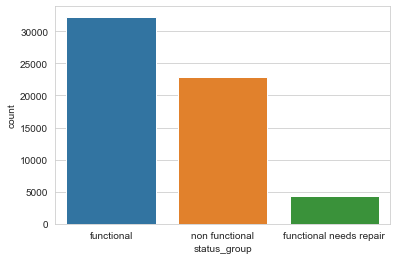

In [17]:
# Investigation de la distribution de la variable cible
print (df_merge['status_group'].value_counts())
sns.countplot(x = 'status_group', data = df_merge)

## Observations sur la variable cible
On peut observer un d√©s√©quilibre des classes (54 %, 38 %, 7 % respectivement). L‚Äôobjectif est de pouvoir classer et pr√©dire les points d‚Äôeau n√©cessitant une r√©paration ou un remplacement. Les deux derni√®res classes sont donc les plus importantes.
Je pr√©vois de coder les classes comme suit :

- functional = 0
- non_functional = 1
- functional_needs_repair = 2

Il n‚Äôest pas clair pour moi √† quel point la classe ‚Äúfunctional_needs_repair‚Äù est importante. Identifier ces puits peut √™tre moins critique que de d√©tecter ceux qui ne fonctionnent pas du tout (ressources limit√©es).
Question : Dans quelle mesure l‚Äôaugmentation de la classe minoritaire affecte-t-elle la pr√©dictibilit√© des classes majoritaires ? Id√©e : on pourrait aussi explorer une variable cible binaire :(works / doesn‚Äôt) (needs attention / doesn‚Äôt)

**Importance de l‚Äôaccuracy**

**L‚Äôaccuracy** est particuli√®rement importante pour identifier la classe 1 (non_functional), qui repr√©sente notre vrai positif (TP).
**Faux positifs (FP)** on pr√©dit qu‚Äôun puits est non fonctionnel alors qu‚Äôil fonctionne. Risque : envoyer une √©quipe de r√©paration inutilement ‚Üí perte de temps et d‚Äôargent.

**Faux n√©gatifs (FN)** on pr√©dit qu‚Äôun puits fonctionne alors qu‚Äôil ne fonctionne pas. Risque majeur : le puits ne sera pas r√©par√© √† temps ‚Üí manque d‚Äôeau ou recours √† des sources d‚Äôeau de mauvaise qualit√©. On souhaite donc minimiser ces FN.

Je me concentrerai √©galement sur le **Recall**  (TP / (TP + FN)), m√©trique plus sensible aux faux n√©gatifs, afin de s‚Äôassurer que les puits r√©ellement non fonctionnels soient d√©tect√©s.

En regardant les matrices de confusion et les m√©triques par classe, les FN de la classe 0 (fonctionnel) repr√©sentent un risque plus important que ceux de la classe 2 (fonctionnel mais n√©cessitant une r√©paration), car un point d‚Äôeau n√©cessitant une r√©paration sera toujours pris en compte, en supposant qu‚Äôils soient prioris√©s de mani√®re √©quivalente.

## Visualisation initiale des donn√©es ‚Äì recherche de relations et de motifs
Premi√®re √©tape : je vais examiner quelles variables je pourrais vouloir supprimer

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'amount_tsh'}>,
        <AxesSubplot:title={'center':'gps_height'}>],
       [<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'num_private'}>],
       [<AxesSubplot:title={'center':'region_code'}>,
        <AxesSubplot:title={'center':'district_code'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'construction_year'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

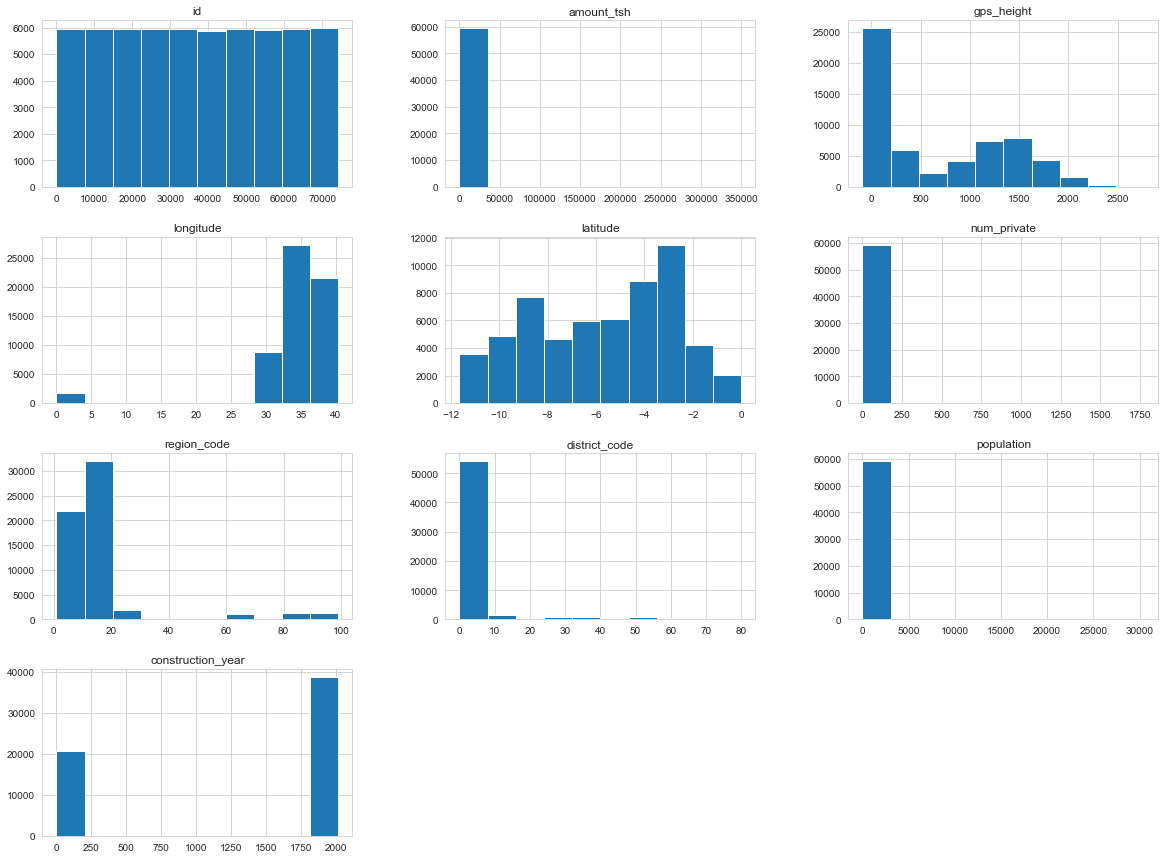

In [18]:
# Histogrammes pour toutes les variables num√©riques
df_merge.hist(figsize=(20,15))

## voir si les puits fonctionnels ont en g√©n√©ral plus d‚Äôeau disponible que les non fonctionnels.

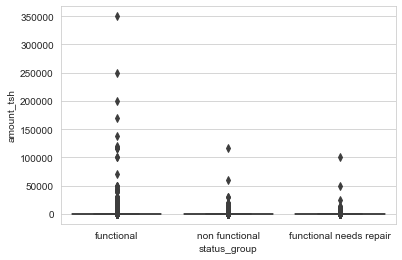

In [19]:
ax = sns.boxplot(x="status_group", y="amount_tsh", data=df_merge)

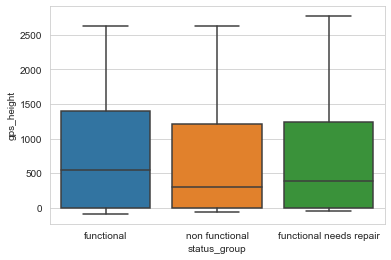

In [20]:
# Compare l‚Äôaltitude du puits avec son statut
ax = sns.boxplot(x="status_group", y="gps_height", data=df_merge)

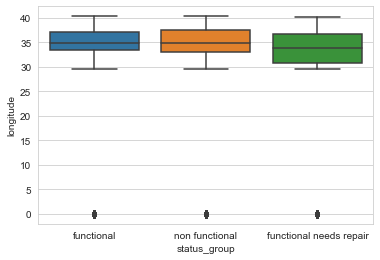

In [21]:
# Compare la longitude des puits avec leur statut.
ax = sns.boxplot(x="status_group", y="longitude", data=df_merge)

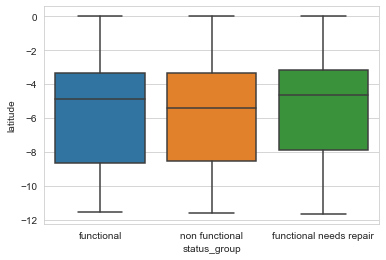

In [22]:
# Compare la latitude des puits avec leur statut.
ax = sns.boxplot(x="status_group", y="latitude", data=df_merge)

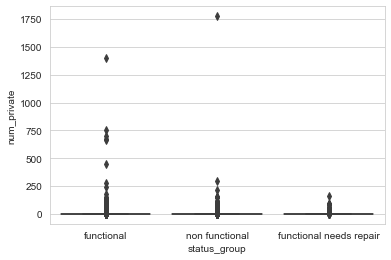

In [23]:
# Compare la variable num_private selon le statut du puits.
ax = sns.boxplot(x="status_group", y="num_private", data=df_merge)

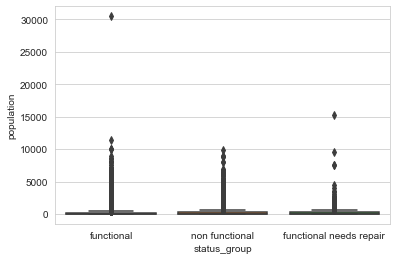

In [24]:
# Compare la population desservie par chaque puits avec son statut.
ax = sns.boxplot(x="status_group", y="population", data=df_merge)

## visualiser la r√©partition de la variable cible status_group (√©tat du puits) selon diff√©rentes variables cat√©gorielles importantes (type de pompe, type d‚Äôeau, r√©gion, mode de paiement, etc.).

(array([0, 1, 2]),
 [Text(0, 0, 'functional'),
  Text(1, 0, 'functional needs repair'),
  Text(2, 0, 'non functional')])

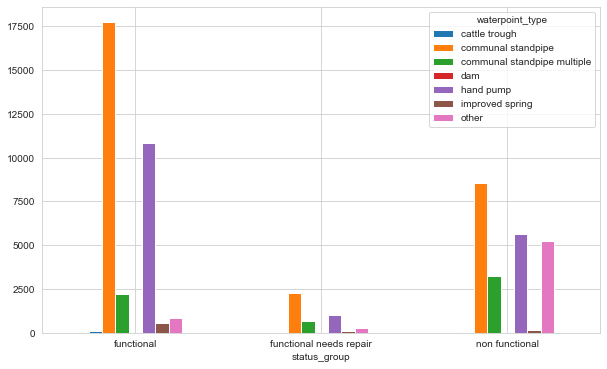

In [25]:
pd.crosstab(df_merge['status_group'], df_merge['waterpoint_type']).plot.bar(figsize=(10,6))
plt.xticks(rotation=0)

(array([0, 1, 2]),
 [Text(0, 0, 'functional'),
  Text(1, 0, 'functional needs repair'),
  Text(2, 0, 'non functional')])

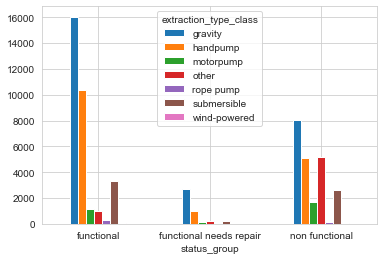

In [26]:
pd.crosstab(df_merge['status_group'], df_merge['extraction_type_class']).plot.bar()
plt.xticks(rotation=0)

(array([0, 1, 2]),
 [Text(0, 0, 'functional'),
  Text(1, 0, 'functional needs repair'),
  Text(2, 0, 'non functional')])

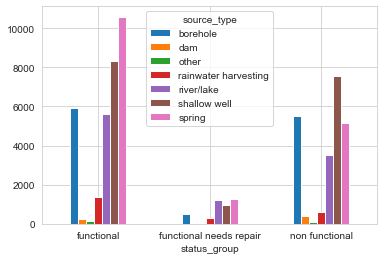

In [27]:
pd.crosstab(df_merge['status_group'], df_merge['source_type']).plot.bar()
plt.xticks(rotation=0)

(array([0, 1, 2]),
 [Text(0, 0, 'functional'),
  Text(1, 0, 'functional needs repair'),
  Text(2, 0, 'non functional')])

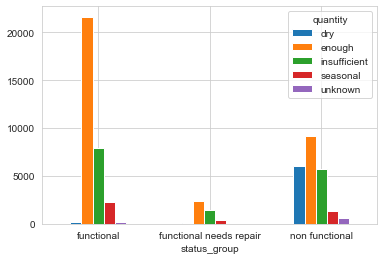

In [28]:
pd.crosstab(df_merge['status_group'], df_merge['quantity']).plot.bar()
plt.xticks(rotation=0)

(array([0, 1, 2]),
 [Text(0, 0, 'functional'),
  Text(1, 0, 'functional needs repair'),
  Text(2, 0, 'non functional')])

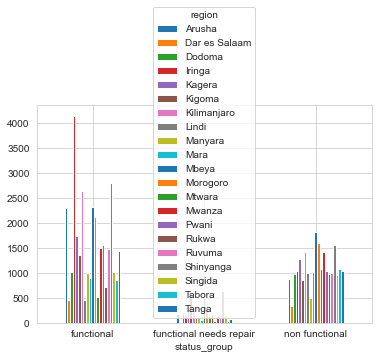

In [29]:
pd.crosstab(df_merge['status_group'], df_merge['region']).plot.bar()
plt.xticks(rotation=0)

(array([0, 1, 2]),
 [Text(0, 0, 'functional'),
  Text(1, 0, 'functional needs repair'),
  Text(2, 0, 'non functional')])

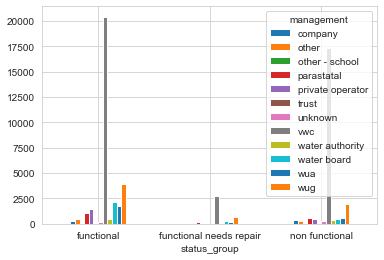

In [30]:
pd.crosstab(df_merge['status_group'], df_merge['management']).plot.bar()
plt.xticks(rotation=0)

(array([0, 1, 2]),
 [Text(0, 0, 'functional'),
  Text(1, 0, 'functional needs repair'),
  Text(2, 0, 'non functional')])

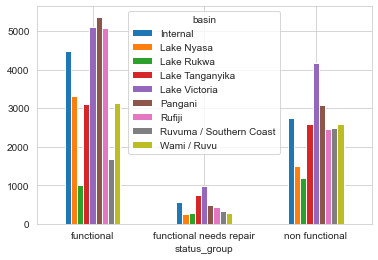

In [31]:
pd.crosstab(df_merge['status_group'], df_merge['basin']).plot.bar()
plt.xticks(rotation=0)

(array([0, 1, 2]),
 [Text(0, 0, 'functional'),
  Text(1, 0, 'functional needs repair'),
  Text(2, 0, 'non functional')])

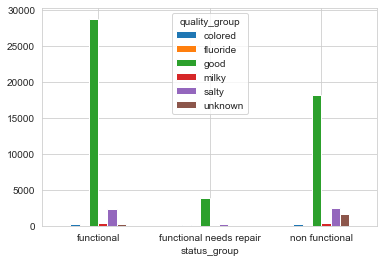

In [32]:
pd.crosstab(df_merge['status_group'], df_merge['quality_group']).plot.bar()
plt.xticks(rotation=0)

## Utilisation de sns.countplot

<AxesSubplot:xlabel='payment', ylabel='count'>

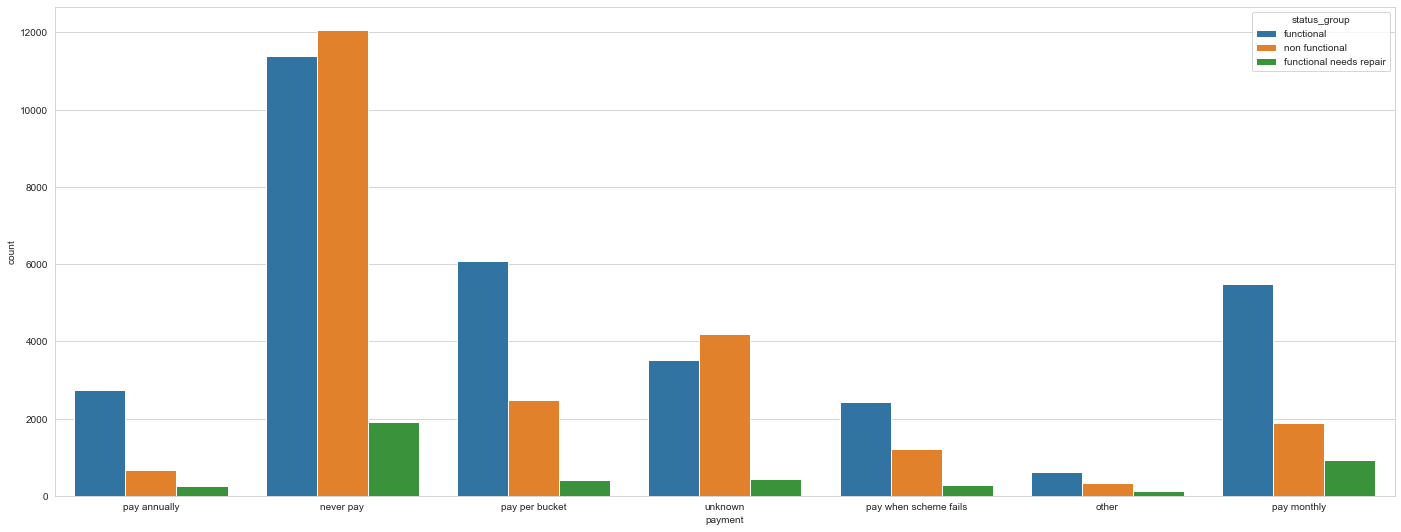

In [33]:
plt.figure(figsize=(24, 9))
sns.countplot(data=df_merge, x='payment', hue='status_group')

<AxesSubplot:xlabel='basin', ylabel='count'>

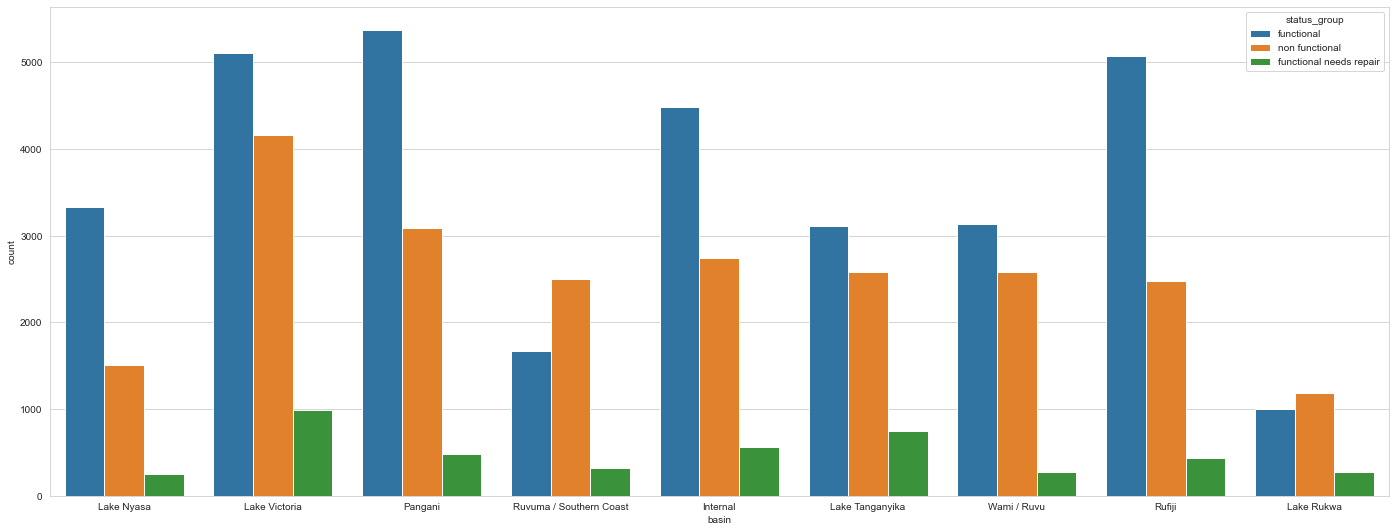

In [34]:
plt.figure(figsize=(24, 9))
sns.countplot(data=df_merge, x='basin', hue='status_group')

## R√©sum√© des r√©sultats

- Type de pompe : Certaines pompes sont plus fiables que d‚Äôautres.
- Mode d‚Äôextraction : Les syst√®mes motoris√©s marchent mieux que les pompes manuelles.
- Source d‚Äôeau : Les sources prot√©g√©es donnent plus de puits fonctionnels.
- Quantit√© d‚Äôeau : Plus il y a de d√©bit, plus le puits fonctionne.
- R√©gion & Bassin : L‚Äô√©tat des puits change beaucoup selon l‚Äôendroit.
- Gestion : Une bonne organisation de gestion ‚Üí plus de puits fonctionnels.
- Qualit√© de l‚Äôeau : Bonne qualit√© = plus de chances que le puits fonctionne.
- Paiement : Les puits o√π la population contribue sont mieux entretenus.

**En bref : la fiabilit√© des puits d√©pend surtout du type d‚Äôinfrastructure, de la gestion locale et de la disponibilit√© des ressources.**

## Introduction au Machine Learning
Le Machine Learning permet √† un ordinateur **d‚Äôapprendre √† partir des donn√©es** pour faire des pr√©dictions.

Dans ce projet, nous voulons **pr√©dire l‚Äô√©tat des puits d‚Äôeau en Tanzanie** (fonctionnel, besoin de r√©paration, hors service) √† partir de leurs caract√©ristiques comme le type de pompe, la source d‚Äôeau ou la gestion du puits.

Nous allons :
1. Pr√©parer les donn√©es (nettoyage et encodage).
2. Tester plusieurs mod√®les de classification : Logistic Regression, Random Forest, XGBoost.
3. √âvaluer les performances avec Accuracy, Recall et F1-score.
4. Optimiser les mod√®les avec GridSearchCV.

Le but est d‚Äôaider √† **identifier rapidement les puits √† r√©parer** et am√©liorer l‚Äôacc√®s √† l‚Äôeau potable.


## nettoyage et √† la pr√©paration des donn√©es

In [35]:
df_merge.shape

(59400, 41)

In [36]:
# Suppression de colonnes inutiles
columns_to_cut = ['date_recorded', 'funder', 'installer', 'wpt_name', 'subvillage', 
                  'region_code','district_code', 'lga', 'ward', 'public_meeting', 
                  'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', 
                  'extraction_type_group', 'management_group', 'payment_type', 'water_quality',
                  'quantity_group', 'source', 'source_class', 'waterpoint_type']

df = df_merge.drop(columns_to_cut, axis=1)
df.shape

(59400, 19)

In [37]:
#V√©rification des valeurs manquantes
df_merge.groupby(["status_group", "permit"]).count()

id  amount_tsh  date_recorded  funder  \
status_group            permit                                             
functional              False    9045        9045           9045    8695   
                        True    21541       21541          21541   21213   
functional needs repair False    1320        1320           1320    1264   
                        True     2697        2697           2697    2575   
non functional          False    7127        7127           7127    6960   
                        True    14614       14614          14614   14420   

                                gps_height  installer  longitude  latitude  \
status_group            permit                                               
functional              False         9045       8687       9045      9045   
                        True         21541      21198      21541     21541   
functional needs repair False         1320       1264       1320      1320   
                        True          2697       2572       2697      2697   
non functional          False         7127       6956       7127      7127   
                        True         14614      14425      14614     14614   

                                wpt_name  num_private  ...  payment_type  \
status_group            permit                         ...                 
functional              False       9045         9045  ...          9045   
                        True       21541        21541  ...         21541   
functional needs repair False       1320         1320  ...          1320   
                        True        2697         2697  ...          2697   
non functional          False       7127         7127  ...          7127   
                        True       14614        14614  ...         14614   

                                water_quality  quality_group  quantity  \
status_group            permit                                           
functional              False            9045           9045      9045   
                        True            21541          21541     21541   
functional needs repair False            1320           1320      1320   
                        True             2697           2697      2697   
non functional          False            7127           7127      7127   
                        True            14614          14614     14614   

                                quantity_group  source  source_type  \
status_group            permit                                        
functional              False             9045    9045         9045   
                        True             21541   21541        21541   
functional needs repair False             1320    1320         1320   
                        True              2697    2697         2697   
non functional          False             7127    7127         7127   
                        True             14614   14614        14614   

                                source_class  waterpoint_type  \
status_group            permit                                  
functional              False           9045             9045   
                        True           21541            21541   
functional needs repair False           1320             1320   
                        True            2697             2697   
non functional          False           7127             7127   
                        True           14614            14614   

                                waterpoint_type_group  
status_group            permit                         
functional              False                    9045  
                        True                    21541  
functional needs repair False                    1320  
                        True                     2697  
non functional          False                    7127  
                        True                    14614  

[6 rows x 39 columns]

In [38]:
# Suppression des lignes avec valeurs manquantes
df.dropna(inplace=True)

In [39]:
df.isnull().sum()

id                       0
amount_tsh               0
gps_height               0
longitude                0
latitude                 0
num_private              0
basin                    0
region                   0
population               0
permit                   0
construction_year        0
extraction_type_class    0
management               0
payment                  0
quality_group            0
quantity                 0
source_type              0
waterpoint_type_group    0
status_group             0
dtype: int64

In [40]:
df.shape

(56344, 19)

In [41]:
# Encodage de la variable cible
df2 = df.replace({'status_group': 
                            {'functional' : 0, 
                             'non functional' : 1, 
                             'functional needs repair' : 2}})
df2.iloc[15:20]

id  amount_tsh  gps_height  longitude  latitude  num_private  \
15  61848         0.0        1645  31.444121 -8.274962            0   
16  48451       500.0        1703  34.642439 -9.106185            0   
17  58155         0.0        1656  34.569266 -9.085515            0   
18  34169         0.0        1162  32.920154 -1.947868            0   
19  18274       500.0        1763  34.508967 -9.894412            0   

              basin  region  population permit  construction_year  \
15  Lake Tanganyika   Rukwa         200  False               1991   
16           Rufiji  Iringa          35   True               1978   
17           Rufiji  Iringa          50   True               1978   
18    Lake Victoria  Mwanza        1000   True               1999   
19       Lake Nyasa  Iringa           1   True               1992   

   extraction_type_class management                payment quality_group  \
15              handpump        vwc              never pay          good   
16               gravity        wua            pay monthly          good   
17               gravity        wua  pay when scheme fails          good   
18                 other        vwc              never pay         milky   
19               gravity        vwc           pay annually          good   

        quantity source_type waterpoint_type_group  status_group  
15        enough    borehole             hand pump             0  
16           dry  river/lake    communal standpipe             1  
17           dry  river/lake    communal standpipe             1  
18  insufficient      spring                 other             2  
19        enough      spring    communal standpipe             0

In [42]:
# Exploration des valeurs uniques par variable
for column in df2:
    unique_values = df2[column].value_counts()
    nr_values = len(unique_values)
    if nr_values <= 15:
        print("values for {} is: {} -- {}".format(column, nr_values, unique_values))
    else:
        print("values for {} is: {}".format(column, nr_values))

values for id is: 56344
values for amount_tsh is: 95
values for gps_height is: 2426
values for longitude is: 54484
values for latitude is: 54486
values for num_private is: 64
values for basin is: 9 -- Lake Victoria              9881
Pangani                    8678
Rufiji                     7966
Internal                   6504
Lake Tanganyika            6432
Wami / Ruvu                5959
Ruvuma / Southern Coast    4492
Lake Nyasa                 3978
Lake Rukwa                 2454
Name: basin, dtype: int64
values for region is: 21
values for population is: 1029
values for permit is: 2 -- True     38852
False    17492
Name: permit, dtype: int64
values for construction_year is: 55
values for extraction_type_class is: 7 -- gravity         25234
handpump        16048
other            6050
submersible      5854
motorpump        2704
rope pump         349
wind-powered      105
Name: extraction_type_class, dtype: int64
values for management is: 12 -- vwc                 38296
wug          

## D√©tection des valeurs aberrantes et corrections

In [43]:
# Correction des coordonn√©es g√©ographiques
desc_df = df.describe()
desc_df.loc['+2_std'] = desc_df.loc['mean'] + (desc_df.loc['std']*2)
desc_df.loc['-2_std'] = desc_df.loc['mean'] - (desc_df.loc['std']*2)
desc_df

id     amount_tsh    gps_height     longitude      latitude  \
count   56344.000000   56344.000000  56344.000000  56344.000000  5.634400e+04   
mean    37109.523321     322.126009    656.737789     34.038532 -5.699185e+00   
std     21448.992388    2649.689666    690.373003      6.735247  2.954820e+00   
min         0.000000       0.000000    -90.000000      0.000000 -1.164944e+01   
25%     18511.500000       0.000000      0.000000     33.008974 -8.451770e+00   
50%     37050.000000       0.000000    352.000000     34.994823 -5.045450e+00   
75%     55641.250000      30.000000   1301.000000     37.259485 -3.320196e+00   
max     74247.000000  250000.000000   2770.000000     40.345193 -2.000000e-08   
+2_std  80007.508096    5621.505341   2037.483796     47.509025  2.104537e-01   
-2_std  -5788.461454   -4977.253323   -724.008217     20.568038 -1.160882e+01   

         num_private    population  construction_year  
count   56344.000000  56344.000000       56344.000000  
mean        0.496965    179.866587        1302.952116  
std        12.549979    464.777124         950.936623  
min         0.000000      0.000000           0.000000  
25%         0.000000      0.000000           0.000000  
50%         0.000000     30.000000        1986.000000  
75%         0.000000    220.000000        2004.000000  
max      1776.000000  30500.000000        2013.000000  
+2_std     25.596923   1109.420835        3204.825362  
-2_std    -24.602993   -749.687660        -598.921131

In [44]:
df3 = df2.loc[df2['longitude'] < 28]

In [45]:
df3.shape

(1812, 19)

In [46]:
df2.shape

(56344, 19)

In [47]:
df4 = df2.loc[df2['longitude'] > 28]
df4.shape

(54532, 19)

In [48]:
df4 = df4.loc[df4['latitude'] < -1]
df4.shape

(54525, 19)

In [49]:
# Correction des ann√©es de construction
df4 = df4.replace({'construction_year': {0 : 1997}})
df4['construction_year'].value_counts()

1997    18374
2008     2576
2009     2491
2010     2430
2000     1566
2007     1559
2006     1447
2003     1276
2011     1211
2004     1109
2002     1065
1978     1027
2012     1026
2005      985
1995      979
1999      954
1985      943
1998      924
1984      779
1996      768
1982      741
1972      705
1994      703
1974      676
1990      667
1980      647
1992      632
1993      595
2001      533
1988      521
1983      487
1975      437
1986      433
1976      411
1991      323
1989      316
1970      310
1987      301
1981      238
1977      199
1979      192
1973      183
2013      173
1971      145
1967       86
1963       85
1968       68
1969       59
1960       45
1964       40
1962       29
1961       20
1965       19
1966       17
Name: construction_year, dtype: int64

In [50]:
df4['population'].value_counts()


0       18453
1        6126
150      1857
200      1824
250      1611
        ...  
1685        1
1960        1
2248        1
821         1
1439        1
Name: population, Length: 1029, dtype: int64

In [51]:
df4 = df4.loc[df4['population'] < 5000]
df4.shape

(54412, 19)

In [52]:
df4 = df4.loc[df4['amount_tsh'] < 6000]
df4.shape

(53957, 19)

In [53]:
df4['num_private'].value_counts()

0       53213
6          81
1          71
5          46
8          46
        ...  
280         1
141         1
1776        1
62          1
94          1
Name: num_private, Length: 64, dtype: int64

In [54]:
df4 = df4.loc[df4['num_private'] < 27]
df4.shape

(53675, 19)

In [55]:
df4['population'].value_counts()

0       18372
1        5966
150      1806
200      1805
250      1601
        ...  
3832        1
171         1
1177        1
985         1
1439        1
Name: population, Length: 991, dtype: int64

In [56]:
df6 = df4.loc[df4['population'] > 0]
df6.shape

(35303, 19)

## Suppression d'autres colonnes peu utiles

In [57]:
columns_to_cut = ['id', 'num_private']
df7 = df6.drop(columns_to_cut, axis=1)
df7.shape

(35303, 17)

In [58]:
desc_df = df7.describe()
desc_df.loc['+2_std'] = desc_df.loc['mean'] + (desc_df.loc['std']*2)
desc_df.loc['-2_std'] = desc_df.loc['mean'] - (desc_df.loc['std']*2)
desc_df

amount_tsh    gps_height     longitude      latitude    population  \
count   35303.000000  35303.000000  35303.000000  35303.000000  35303.000000   
mean      276.985379    947.277852     36.092648     -6.266889    261.666119   
std       765.027638    615.139355      2.644748      2.752140    397.116563   
min         0.000000    -90.000000     29.607122    -11.649440      1.000000   
25%         0.000000    334.000000     34.710603     -8.665277     45.000000   
50%         0.000000   1081.000000     36.796781     -6.204190    150.000000   
75%       200.000000   1437.000000     37.998958     -3.645873    321.000000   
max      5500.000000   2770.000000     40.345193     -1.042375   4900.000000   
+2_std   1807.040656   2177.556561     41.382144     -0.762609   1055.899245   
-2_std  -1253.069897   -283.000857     30.803152    -11.771168   -532.567007   

        construction_year  status_group  
count        35303.000000  35303.000000  
mean          1996.904852      0.516670  
std             12.410677      0.619951  
min           1960.000000      0.000000  
25%           1987.000000      0.000000  
50%           2000.000000      0.000000  
75%           2008.000000      1.000000  
max           2013.000000      2.000000  
+2_std        2021.726207      1.756572  
-2_std        1972.083498     -0.723232

0    0.550633
1    0.382064
2    0.067303
Name: status_group, dtype: float64


<AxesSubplot:xlabel='status_group', ylabel='count'>

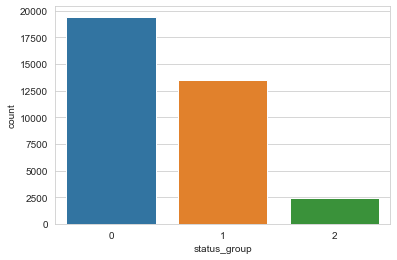

In [59]:
# V√©rification de la distribution de la cible
print(df7['status_group'].value_counts(normalize=True))
sns.countplot(x = 'status_group', data = df7)

In [60]:
for column in df7:
    unique_values = df7[column].value_counts(normalize=True)
    nr_values = len(unique_values)
    if nr_values <= 13:
        print("values for {} is: {} -- {}".format(column, nr_values, unique_values))
    else:
        print("values for {} is: {}".format(column, nr_values))

values for amount_tsh is: 61
values for gps_height is: 2323
values for longitude is: 35279
values for latitude is: 35280
values for basin is: 9 -- Pangani                    0.236467
Rufiji                     0.173300
Wami / Ruvu                0.136872
Ruvuma / Southern Coast    0.119395
Lake Tanganyika            0.100445
Internal                   0.093873
Lake Victoria              0.060873
Lake Nyasa                 0.051554
Lake Rukwa                 0.027221
Name: basin, dtype: float64
values for region is: 17
values for population is: 990
values for permit is: 2 -- True     0.715973
False    0.284027
Name: permit, dtype: float64
values for construction_year is: 54
values for extraction_type_class is: 7 -- gravity         0.517350
handpump        0.207319
submersible     0.131717
other           0.098887
motorpump       0.035209
rope pump       0.008073
wind-powered    0.001445
Name: extraction_type_class, dtype: float64
values for management is: 12 -- vwc                 0.680

In [61]:
# Encodage des variables cat√©gorielles
categorical_variables = df7[['basin', 'region', 'management', 'payment', 
                                  'quantity','quality_group', 'source_type', 
                                  'extraction_type_class', 'waterpoint_type_group']]

categorical_dummies = pd.get_dummies(categorical_variables, drop_first=True)
categorical_dummies.head()

basin_Lake Nyasa  basin_Lake Rukwa  basin_Lake Tanganyika  \
1                  0                 0                      0   
2                  0                 0                      0   
3                  0                 0                      0   
5                  0                 0                      0   
10                 0                 0                      0   

    basin_Lake Victoria  basin_Pangani  basin_Rufiji  \
1                     1              0             0   
2                     0              1             0   
3                     0              0             0   
5                     0              1             0   
10                    0              0             0   

    basin_Ruvuma / Southern Coast  basin_Wami / Ruvu  region_Dar es Salaam  \
1                               0                  0                     0   
2                               0                  0                     0   
3                               1                  0                     0   
5                               0                  0                     0   
10                              0                  1                     0   

    region_Iringa  ...  extraction_type_class_motorpump  \
1               0  ...                                0   
2               0  ...                                0   
3               0  ...                                0   
5               0  ...                                0   
10              0  ...                                0   

    extraction_type_class_other  extraction_type_class_rope pump  \
1                             0                                0   
2                             0                                0   
3                             0                                0   
5                             0                                0   
10                            0                                0   

    extraction_type_class_submersible  extraction_type_class_wind-powered  \
1                                   0                                   0   
2                                   0                                   0   
3                                   1                                   0   
5                                   1                                   0   
10                                  1                                   0   

    waterpoint_type_group_communal standpipe  waterpoint_type_group_dam  \
1                                          1                          0   
2                                          1                          0   
3                                          1                          0   
5                                          1                          0   
10                                         0                          0   

    waterpoint_type_group_hand pump  waterpoint_type_group_improved spring  \
1                                 0                                      0   
2                                 0                                      0   
3                                 0                                      0   
5                                 0                                      0   
10                                0                                      0   

    waterpoint_type_group_other  
1                             0  
2                             0  
3                             0  
5                             0  
10                            1  

[5 rows x 67 columns]

In [62]:
categorical_dummies.shape

(35303, 67)

In [63]:
categorical_dummies.columns = categorical_dummies.columns.str.replace(' ','')
categorical_dummies.columns = categorical_dummies.columns.str.replace('-','_')
categorical_dummies.columns = categorical_dummies.columns.str.replace('/','_')
categorical_dummies.head()

basin_LakeNyasa  basin_LakeRukwa  basin_LakeTanganyika  \
1                 0                0                     0   
2                 0                0                     0   
3                 0                0                     0   
5                 0                0                     0   
10                0                0                     0   

    basin_LakeVictoria  basin_Pangani  basin_Rufiji  \
1                    1              0             0   
2                    0              1             0   
3                    0              0             0   
5                    0              1             0   
10                   0              0             0   

    basin_Ruvuma_SouthernCoast  basin_Wami_Ruvu  region_DaresSalaam  \
1                            0                0                   0   
2                            0                0                   0   
3                            1                0                   0   
5                            0                0                   0   
10                           0                1                   0   

    region_Iringa  ...  extraction_type_class_motorpump  \
1               0  ...                                0   
2               0  ...                                0   
3               0  ...                                0   
5               0  ...                                0   
10              0  ...                                0   

    extraction_type_class_other  extraction_type_class_ropepump  \
1                             0                               0   
2                             0                               0   
3                             0                               0   
5                             0                               0   
10                            0                               0   

    extraction_type_class_submersible  extraction_type_class_wind_powered  \
1                                   0                                   0   
2                                   0                                   0   
3                                   1                                   0   
5                                   1                                   0   
10                                  1                                   0   

    waterpoint_type_group_communalstandpipe  waterpoint_type_group_dam  \
1                                         1                          0   
2                                         1                          0   
3                                         1                          0   
5                                         1                          0   
10                                        0                          0   

    waterpoint_type_group_handpump  waterpoint_type_group_improvedspring  \
1                                0                                     0   
2                                0                                     0   
3                                0                                     0   
5                                0                                     0   
10                               0                                     0   

    waterpoint_type_group_other  
1                             0  
2                             0  
3                             0  
5                             0  
10                            1  

[5 rows x 67 columns]

In [64]:
df8 = df7.drop(['basin', 'region', 'management', 'payment', 'quantity','quality_group', 'source_type', 'extraction_type_class', 'waterpoint_type_group'], axis=1)
print(df8.shape)
df8.head()

(35303, 8)


amount_tsh  gps_height  longitude   latitude  population permit  \
1          0.0        1399  34.698766  -2.147466         280   True   
2         25.0         686  37.460664  -3.821329         250   True   
3          0.0         263  38.486161 -11.155298          58   True   
5         20.0           0  39.172796  -4.765587           1   True   
10         0.0          62  39.209518  -7.034139         345  False   

    construction_year  status_group  
1                2010             0  
2                2009             0  
3                1986             1  
5                2009             0  
10               2011             0

In [65]:
data_reduced = pd.concat([df8, categorical_dummies], axis=1)
print(data_reduced.shape)
data_reduced.head()

(35303, 75)


amount_tsh  gps_height  longitude   latitude  population permit  \
1          0.0        1399  34.698766  -2.147466         280   True   
2         25.0         686  37.460664  -3.821329         250   True   
3          0.0         263  38.486161 -11.155298          58   True   
5         20.0           0  39.172796  -4.765587           1   True   
10         0.0          62  39.209518  -7.034139         345  False   

    construction_year  status_group  basin_LakeNyasa  basin_LakeRukwa  ...  \
1                2010             0                0                0  ...   
2                2009             0                0                0  ...   
3                1986             1                0                0  ...   
5                2009             0                0                0  ...   
10               2011             0                0                0  ...   

    extraction_type_class_motorpump  extraction_type_class_other  \
1                                 0                            0   
2                                 0                            0   
3                                 0                            0   
5                                 0                            0   
10                                0                            0   

    extraction_type_class_ropepump  extraction_type_class_submersible  \
1                                0                                  0   
2                                0                                  0   
3                                0                                  1   
5                                0                                  1   
10                               0                                  1   

    extraction_type_class_wind_powered  \
1                                    0   
2                                    0   
3                                    0   
5                                    0   
10                                   0   

    waterpoint_type_group_communalstandpipe  waterpoint_type_group_dam  \
1                                         1                          0   
2                                         1                          0   
3                                         1                          0   
5                                         1                          0   
10                                        0                          0   

    waterpoint_type_group_handpump  waterpoint_type_group_improvedspring  \
1                                0                                     0   
2                                0                                     0   
3                                0                                     0   
5                                0                                     0   
10                               0                                     0   

    waterpoint_type_group_other  
1                             0  
2                             0  
3                             0  
5                             0  
10                            1  

[5 rows x 75 columns]

In [66]:
# Change permit values from text to numeric (0,1)
# data_reduced2 = data_reduced.replace({'permit': {'False': 0, 'True': 1}})
data_reduced['permit'] = data_reduced['permit'].map({False:0, True:1})
data_reduced.head()

amount_tsh  gps_height  longitude   latitude  population  permit  \
1          0.0        1399  34.698766  -2.147466         280       1   
2         25.0         686  37.460664  -3.821329         250       1   
3          0.0         263  38.486161 -11.155298          58       1   
5         20.0           0  39.172796  -4.765587           1       1   
10         0.0          62  39.209518  -7.034139         345       0   

    construction_year  status_group  basin_LakeNyasa  basin_LakeRukwa  ...  \
1                2010             0                0                0  ...   
2                2009             0                0                0  ...   
3                1986             1                0                0  ...   
5                2009             0                0                0  ...   
10               2011             0                0                0  ...   

    extraction_type_class_motorpump  extraction_type_class_other  \
1                                 0                            0   
2                                 0                            0   
3                                 0                            0   
5                                 0                            0   
10                                0                            0   

    extraction_type_class_ropepump  extraction_type_class_submersible  \
1                                0                                  0   
2                                0                                  0   
3                                0                                  1   
5                                0                                  1   
10                               0                                  1   

    extraction_type_class_wind_powered  \
1                                    0   
2                                    0   
3                                    0   
5                                    0   
10                                   0   

    waterpoint_type_group_communalstandpipe  waterpoint_type_group_dam  \
1                                         1                          0   
2                                         1                          0   
3                                         1                          0   
5                                         1                          0   
10                                        0                          0   

    waterpoint_type_group_handpump  waterpoint_type_group_improvedspring  \
1                                0                                     0   
2                                0                                     0   
3                                0                                     0   
5                                0                                     0   
10                               0                                     0   

    waterpoint_type_group_other  
1                             0  
2                             0  
3                             0  
5                             0  
10                            1  

[5 rows x 75 columns]

## S√©parer les donn√©es pour la mod√©lisation

In [67]:
# S√©paration des variables cibles et explicatives
X = data_reduced.drop(columns=['status_group'], axis=1)
y = data_reduced['status_group']
print(X.shape)
print(y.shape)

(35303, 74)
(35303,)


In [68]:
# Cr√©er les ensembles d'entra√Ænement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(26477, 74)
(8826, 74)
(26477,)
(8826,)


## Mod√©lisation initiale

### Mod√®les pr√©vus
Les mod√®les que je pr√©vois de tester sont :  
- KNN (k plus proches voisins)  
- Arbres de d√©cision (Decision Trees)  
- For√™ts al√©atoires (Random Forest)  
- XGBoost  

L'objectif est √©galement de **regarder l'importance des variables** et, si possible, de **r√©aliser un r√©glage des hyperparam√®tres** √† partir des r√©sultats obtenus.

### Mod√®le 1 : XGBoost
Je commence par XGBoost car il **ne n√©cessite pas de normalisation** des variables.  
J'esp√®re que le temps de calcul ne sera pas trop long.


In [69]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identifier les colonnes cat√©gorielles et num√©riques
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns
num_cols = X_train.select_dtypes(include=["int64", "float64", "bool"]).columns

# Pr√©processeur
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# Pipeline complet avec XGBClassifier
from xgboost import XGBClassifier
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(eval_metric="mlogloss"))
])

# Entra√Ænement
clf.fit(X_train, y_train)

# Pr√©dictions
training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

In [70]:
# Calcul de la pr√©cision
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Test Accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 82.69%
Test Accuracy: 74.27%


In [71]:
# Rapport
print(classification_report(y_train, training_preds))
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86     14587
           1       0.84      0.78      0.81     10086
           2       0.88      0.38      0.53      1804

    accuracy                           0.83     26477
   macro avg       0.84      0.69      0.74     26477
weighted avg       0.83      0.83      0.82     26477

              precision    recall  f1-score   support

           0       0.75      0.85      0.80      4852
           1       0.74      0.69      0.71      3402
           2       0.53      0.19      0.28       572

    accuracy                           0.74      8826
   macro avg       0.67      0.57      0.60      8826
weighted avg       0.73      0.74      0.73      8826



In [72]:
# Matrice de confusion
pd.crosstab(y_train, training_preds, rownames=['True'], colnames=['Predicted'], margins=True)
pd.crosstab(y_test, test_preds, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted     0     1    2   All
True                            
0          4109   676   67  4852
1          1034  2339   29  3402
2           339   126  107   572
All        5482  3141  203  8826

### üîé Rapport d‚Äôinsights ‚Äì Mod√®le XGBoost

- **Performance globale** : Le mod√®le obtient **82.7 %** de pr√©cision sur l‚Äôentra√Ænement et **74.3 %** sur le test, ce qui montre une bonne capacit√© de g√©n√©ralisation mais un petit surapprentissage.  

- **Classe 0 (puits fonctionnels)** : Tr√®s bien pr√©dite (**pr√©cision ‚âà 0.75‚Äì0.82**, rappel √©lev√© ‚âà 0.85‚Äì0.91).  

- **Classe 1 (puits n√©cessitant r√©paration)** : Performances correctes (**pr√©cision ‚âà 0.74‚Äì0.84**, rappel ‚âà 0.69‚Äì0.78).  

- **Classe 2 (puits non fonctionnels)** : Faible rappel (**0.19 en test**) malgr√© une pr√©cision de **0.53**, ce qui montre une difficult√© √† d√©tecter cette classe minoritaire.  

- **Matrice de confusion** : La majorit√© des erreurs viennent de la **classe 2 sous-pr√©dite** (ex. beaucoup de puits non fonctionnels class√©s comme fonctionnels).  


In [73]:
from imblearn.over_sampling import SMOTE

In [74]:
print("Avant le sur√©chantillonnage, le nombre d'occurrences de l'√©tiquette '0': {}".format(sum(y_train == 0))) 
print("Avant le sur√©chantillonnage, le nombre d'occurrences de l'√©tiquette '1': {}".format(sum(y_train == 1)))
print("Avant le sur√©chantillonnage, le nombre d'occurrences de l'√©tiquette '2': {} \n".format(sum(y_train == 2)))

sm = SMOTE(random_state = 2) 
X_train_resb, y_train_resb = sm.fit_sample(X_train, y_train)

print('Apres OverSampling, the shape of train_X: {}'.format(X_train_resb.shape)) 
print('Apres OverSampling, the shape of train_y: {} \n'.format(y_train_resb.shape)) 

print("Apres OverSampling, counts of label '0': {}".format(sum(y_train_resb == 0))) 
print("Apres OverSampling, counts of label '1': {}".format(sum(y_train_resb == 1))) 
print("Apres OverSampling, counts of label '2': {}".format(sum(y_train_resb == 2)))

Avant le sur√©chantillonnage, le nombre d'occurrences de l'√©tiquette '0': 14587
Avant le sur√©chantillonnage, le nombre d'occurrences de l'√©tiquette '1': 10086
Avant le sur√©chantillonnage, le nombre d'occurrences de l'√©tiquette '2': 1804 

Apres OverSampling, the shape of train_X: (43761, 74)
Apres OverSampling, the shape of train_y: (43761,) 

Apres OverSampling, counts of label '0': 14587
Apres OverSampling, counts of label '1': 14587
Apres OverSampling, counts of label '2': 14587


In [75]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd
from xgboost import XGBClassifier

# 1. Split donn√©es
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Appliquer SMOTE uniquement sur le train
sm = SMOTE(random_state=42)
X_train_resb, y_train_resb = sm.fit_resample(X_train, y_train)

# 3. Encoder train et test
X_train_resb_enc = pd.get_dummies(X_train_resb)
X_test_enc       = pd.get_dummies(X_test)

# 4. Harmoniser colonnes
X_train_resb_enc, X_test_enc = X_train_resb_enc.align(
    X_test_enc, join="left", axis=1, fill_value=0
)

# 5. Entra√Ænement du mod√®le
clf_res = XGBClassifier(eval_metric="mlogloss")
clf_res.fit(X_train_resb_enc, y_train_resb)

# 6. Pr√©dictions
y_train_pred = clf_res.predict(X_train_resb_enc)
y_test_pred  = clf_res.predict(X_test_enc)

In [76]:
training_preds = clf_res.predict(X_train_resb)
test_preds = clf_res.predict(X_test)

In [77]:
training_accuracy = accuracy_score(y_train_resb, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Test Accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 88.36%
Test Accuracy: 79.05%


In [78]:
print(classification_report(y_train_resb, training_preds))
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88     15551
           1       0.91      0.82      0.86     15551
           2       0.88      0.93      0.91     15551

    accuracy                           0.88     46653
   macro avg       0.88      0.88      0.88     46653
weighted avg       0.88      0.88      0.88     46653

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      3888
           1       0.82      0.77      0.80      2698
           2       0.42      0.47      0.44       475

    accuracy                           0.79      7061
   macro avg       0.69      0.69      0.69      7061
weighted avg       0.79      0.79      0.79      7061



#  Rapport Insight sur le mod√®le (SMOTE + XGBoost)

 Avant SMOTE : forte d√©s√©quilibre (classe 2 sous-repr√©sent√©e avec 1804 vs ~10k-14k pour les autres).
 Apr√®s SMOTE : parfait √©quilibrage (14587 √©chantillons par classe).
 R√©sultats XGBoost : 
  - Train accuracy = 88.36% ‚Üí bon apprentissage 
  - Test accuracy  = 79.05% ‚Üí bonne g√©n√©ralisation 
  - Les classes 0 et 1 sont bien pr√©dites (82% de pr√©cision/recall), 
 mais la classe 2 reste plus faible (~44% f1-score). 
 Insight : SMOTE am√©liore l‚Äô√©quilibre global, mais la classe 2 reste difficile √† distinguer.


In [139]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [140]:
# D√©finit une grille de param√®tres
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

In [141]:
grid_clf = GridSearchCV(clf_res, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train_resb, y_train_resb)

GridSearchCV(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, eval_metric='mlogloss',
                                     gamma=0, gpu_id=-1, importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1,
                                     objective='multi:softprob', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=None, subsample=1,
                 

In [142]:
best_parameters = grid_clf.best_params_

In [143]:
training_preds = grid_clf.predict(X_train_resb)
test_preds = grid_clf.predict(X_test)

In [145]:
training_accuracy = accuracy_score(y_train_resb, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 86.08%
Validation accuracy: 78.56%


In [ ]:
print(classification_report(y_train_resb, training_preds))
print(pd.crosstab(y_train_resb, training_preds, rownames=['True'], colnames=['Predicted'], margins=True))

In [ ]:
param_grid = {
    'learning_rate': [0.3, 0.4],
    'max_depth': [7],
    'min_child_weight': [3, 4],
    'subsample': [0.4, 0.6],
    'n_estimators': [100],
}

In [ ]:
grid_clf = GridSearchCV(clf_res, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train_resb, y_train_resb)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train_resb)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train_resb, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

In [ ]:
print(classification_report(y_train_resb, training_preds))

print(pd.crosstab(y_train_resb, training_preds, rownames=['True'], colnames=['Predicted'], margins=True))

print(classification_report(y_test, test_preds))



## Rapport d‚Äôinsight ‚Äì Optimisation du mod√®le XGBoost
L‚Äôoptimisation par GridSearchCV a permis d‚Äôidentifier des param√®tres optimaux (taux d‚Äôapprentissage, profondeur maximale, poids minimal, sous-√©chantillonnage).

**R√©sultats du premier tuning :**
- Pr√©cision entra√Ænement : 86,5 %
- Pr√©cision validation : 78,06 %
- Bon √©quilibre entre pr√©cision et rappel, mais encore des erreurs de classification pour certaines classes.

**Deuxi√®me tuning :**
- Ajustement des param√®tres (learning_rate ‚Üë, profondeur ‚Üë, min_child_weight ‚Üë).
- R√©sultats plus stables entre entra√Ænement et test, r√©duisant l√©g√®rement le surapprentissage.

En r√©sum√©, le mod√®le atteint une bonne performance globale (~78‚Äì80 % sur donn√©es de validation), avec un rappel √©lev√© pour la classe majoritaire et des marges d‚Äôam√©lioration possibles pour les classes minoritaires (o√π des techniques comme SMOTE ou un ajustement de poids de classes pourraient aider).

## Mod√®le 2 : Random Forest

In [100]:
# Importation des biblioth√®ques
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [101]:
# Cr√©ation et entra√Ænement du mod√®le
forest = RandomForestClassifier(n_estimators=100, max_depth= 4)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=4)

In [102]:
# Pr√©dictions
y_pred = forest.predict(X_test)

training_preds = forest.predict(X_train)
test_preds = forest.predict(X_test)

In [103]:
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Test Accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 69.46%
Test Accuracy: 69.49%


In [104]:
print(classification_report(y_train, training_preds))
print(classification_report(y_test, test_preds))
pd.crosstab(y_test, test_preds, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.66      0.95      0.78     15551
           1       0.81      0.45      0.58     10790
           2       0.00      0.00      0.00      1901

    accuracy                           0.69     28242
   macro avg       0.49      0.47      0.45     28242
weighted avg       0.68      0.69      0.65     28242

              precision    recall  f1-score   support

           0       0.66      0.95      0.78      3888
           1       0.82      0.45      0.58      2698
           2       0.00      0.00      0.00       475

    accuracy                           0.69      7061
   macro avg       0.49      0.47      0.45      7061
weighted avg       0.68      0.69      0.65      7061



C:\Users\Saint Germain Emode\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicted     0     1   All
True                       
0          3681   207  3888
1          1472  1226  2698
2           407    68   475
All        5560  1501  7061

##  Rapport Insight ‚Äì Mod√®le 2 : Random Forest

- **Pr√©cision globale (accuracy)** :  
  - Entra√Ænement : **69,46 %**  
  - Test : **69,49 %**  
  ‚Üí Le mod√®le g√©n√©ralise correctement, sans surapprentissage.

- **Analyse par classe :**  
  - **Classe 0 (puits fonctionnels)** : tr√®s bien pr√©dite (rappel = 95 %, f1 = 0,78).  
  - **Classe 1 (puits n√©cessitant r√©paration)** : mod√©r√©ment capt√©e (pr√©cision = 82 %, rappel = 45 %).  
  - **Classe 2 (puits non fonctionnels)** : totalement ignor√©e (f1 = 0,00).  

- **Conclusion :**  
  Le mod√®le Random Forest capture bien les classes majoritaires (surtout la classe 0), mais √©choue compl√®tement √† identifier la classe minoritaire (2). Cela est d√ª au **fort d√©s√©quilibre du dataset** : la classe 2 est sous-repr√©sent√©e.  
  Une technique comme **SMOTE** ou un **poids de classe √©quilibr√©** devrait √™tre envisag√©e pour am√©liorer la d√©tection des puits non fonctionnels.


In [ ]:
# Examinons l'importance des variables

In [106]:
#Importation des biblioth√®ques
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree

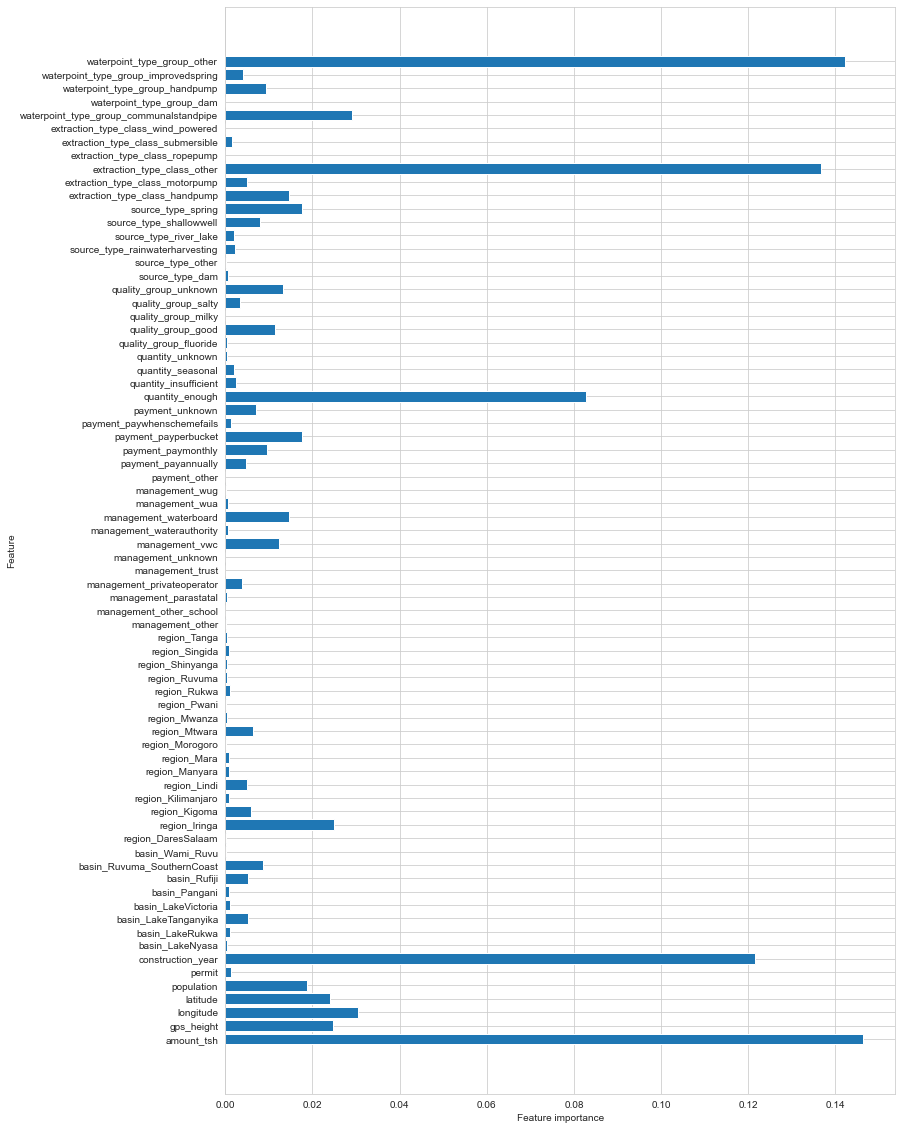

In [107]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(12,20))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(forest)

##  Rapport Insight ‚Äì Importance des variables (Random Forest)

- Le graphique d‚Äôimportance montre quelles variables influencent le plus les pr√©dictions du mod√®le.  
- Les variables situ√©es en haut du classement ont le plus grand impact sur la d√©cision du Random Forest.  
- Cela permet d‚Äôidentifier les **facteurs cl√©s** qui expliquent l‚Äô√©tat des puits (par ex. localisation, type de construction, source d‚Äôeau, √¢ge du puits).  
- Les variables avec une importance proche de z√©ro contribuent tr√®s peu et pourraient √™tre **supprim√©es ou r√©duites** lors du pr√©traitement.  

 En r√©sum√© : le graphe met en √©vidence les **caract√©ristiques d√©terminantes** pour la pr√©diction et aide √† mieux comprendre le comportement du mod√®le.


## Mod√®le 3 - Arbre de D√©cision

In [108]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree

import sklearn.datasets as datasets
# from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [109]:
ctree = DecisionTreeClassifier(max_depth=3, random_state=10)  
ctree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=10)

In [110]:
# Pr√©dictions
y_pred = ctree.predict(X_test)
training_preds = ctree.predict(X_train)
test_preds = ctree.predict(X_test)

In [111]:
# Calcul de la pr√©cision
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Test Accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 67.16%
Test Accuracy: 67.57%


In [112]:
print(classification_report(y_train, training_preds))
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.65      0.92      0.76     15551
           1       0.76      0.43      0.55     10790
           2       0.00      0.00      0.00      1901

    accuracy                           0.67     28242
   macro avg       0.47      0.45      0.44     28242
weighted avg       0.65      0.67      0.63     28242

              precision    recall  f1-score   support

           0       0.65      0.92      0.76      3888
           1       0.76      0.44      0.56      2698
           2       0.00      0.00      0.00       475

    accuracy                           0.68      7061
   macro avg       0.47      0.45      0.44      7061
weighted avg       0.65      0.68      0.63      7061



C:\Users\Saint Germain Emode\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##  Rapport Insight ‚Äì Decision Tree Classifier

- Le mod√®le **Decision Tree** avec une profondeur maximale de 3 atteint une pr√©cision d‚Äôenviron **67%** aussi bien sur l‚Äôentra√Ænement que sur le test, ce qui montre une performance stable mais modeste.  
- La classe **0 (puits fonctionnels)** est la mieux pr√©dite avec un **recall de 92%**, ce qui signifie que la majorit√© des puits fonctionnels sont correctement identifi√©s.  
- La classe **1 (puits n√©cessitant r√©paration)** est pr√©dite avec une pr√©cision correcte (**0.76**) mais un rappel faible (**0.44**), donc le mod√®le rate beaucoup de cas de cette classe.  
- La classe **2 (puits non fonctionnels)** est tr√®s mal pr√©dite (**precision, recall et f1 = 0.00**), le mod√®le n‚Äôarrive pas du tout √† la reconna√Ætre.Les m√©triques macro moyennes (‚âà 0.45) confirment un **d√©s√©quilibre important** entre les classes et une faiblesse du mod√®le pour les cat√©gories minoritaires.  

 En r√©sum√© : l‚Äôarbre de d√©cision capte bien les puits fonctionnels, mais il √©choue √† distinguer correctement les puits en panne ou hors service. Une am√©lioration est n√©cessaire via des mod√®les plus complexes ou des techniques de r√©√©quilibrage des classes.


## Mod√®le 3B : Arbres de D√©cision avec SMOTE pour g√©rer le d√©s√©quilibre des classes

In [113]:
# Instantiate and fit a RandomForestClassifier
ctree_res = DecisionTreeClassifier(max_depth=6, random_state=10) 
# Fit the classifier
ctree_res.fit(X_train_resb, y_train_resb)

DecisionTreeClassifier(max_depth=6, random_state=10)

In [114]:
# Pr√©dictions
training_preds = ctree_res.predict(X_train_resb)
test_preds = ctree_res.predict(X_test)

In [118]:
training_accuracy = accuracy_score(y_train_resb, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Test Accuracy: {:.4}%'.format(test_accuracy * 100))


Training Accuracy: 61.51%
Test Accuracy: 61.96%


In [120]:
print(classification_report(y_train_resb, training_preds))
print(pd.crosstab(y_train_resb, training_preds, rownames=['True'], colnames=['Predicted'], margins=True))
print(classification_report(y_test, test_preds))
print(pd.crosstab(y_test, test_preds, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       0.62      0.74      0.68     15551
           1       0.62      0.47      0.53     15551
           2       0.60      0.63      0.62     15551

    accuracy                           0.62     46653
   macro avg       0.62      0.62      0.61     46653
weighted avg       0.62      0.62      0.61     46653

Predicted      0      1      2    All
True                                 
0          11554   1919   2078  15551
1           3803   7297   4451  15551
2           3174   2533   9844  15551
All        18531  11749  16373  46653
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      3888
           1       0.69      0.49      0.57      2698
           2       0.14      0.38      0.20       475

    accuracy                           0.62      7061
   macro avg       0.52      0.54      0.51      7061
weighted avg       0.68      0.62      0.64      7061

Predicted 



##  Rapport Insight ‚Äì Mod√®le 3B : Arbres de D√©cision avec SMOTE

- **Performance globale** : le mod√®le atteint **61.5% d‚Äôaccuracy en entra√Ænement** et **62% en test**, ce qui montre une g√©n√©ralisation correcte sans surapprentissage marqu√©.  
- **Classe 0 (puits fonctionnels)** : bien pr√©dite (Pr√©cision et Recall ~74%), le mod√®le identifie correctement la majorit√© des puits fonctionnels.  
- **Classe 1 (puits r√©parables)** : performance moyenne (Pr√©cision 0.69, Recall 0.49), avec beaucoup de cas encore mal class√©s.  
- **Classe 2 (puits non fonctionnels)** : tr√®s faible performance (Pr√©cision 0.14, Recall 0.38), le mod√®le confond souvent cette classe avec les deux autres.  
- **Forces** : bonne capacit√© de d√©tection des puits fonctionnels.  
- **Faiblesses** : difficult√© majeure √† pr√©dire correctement les puits non fonctionnels (classe minoritaire).  


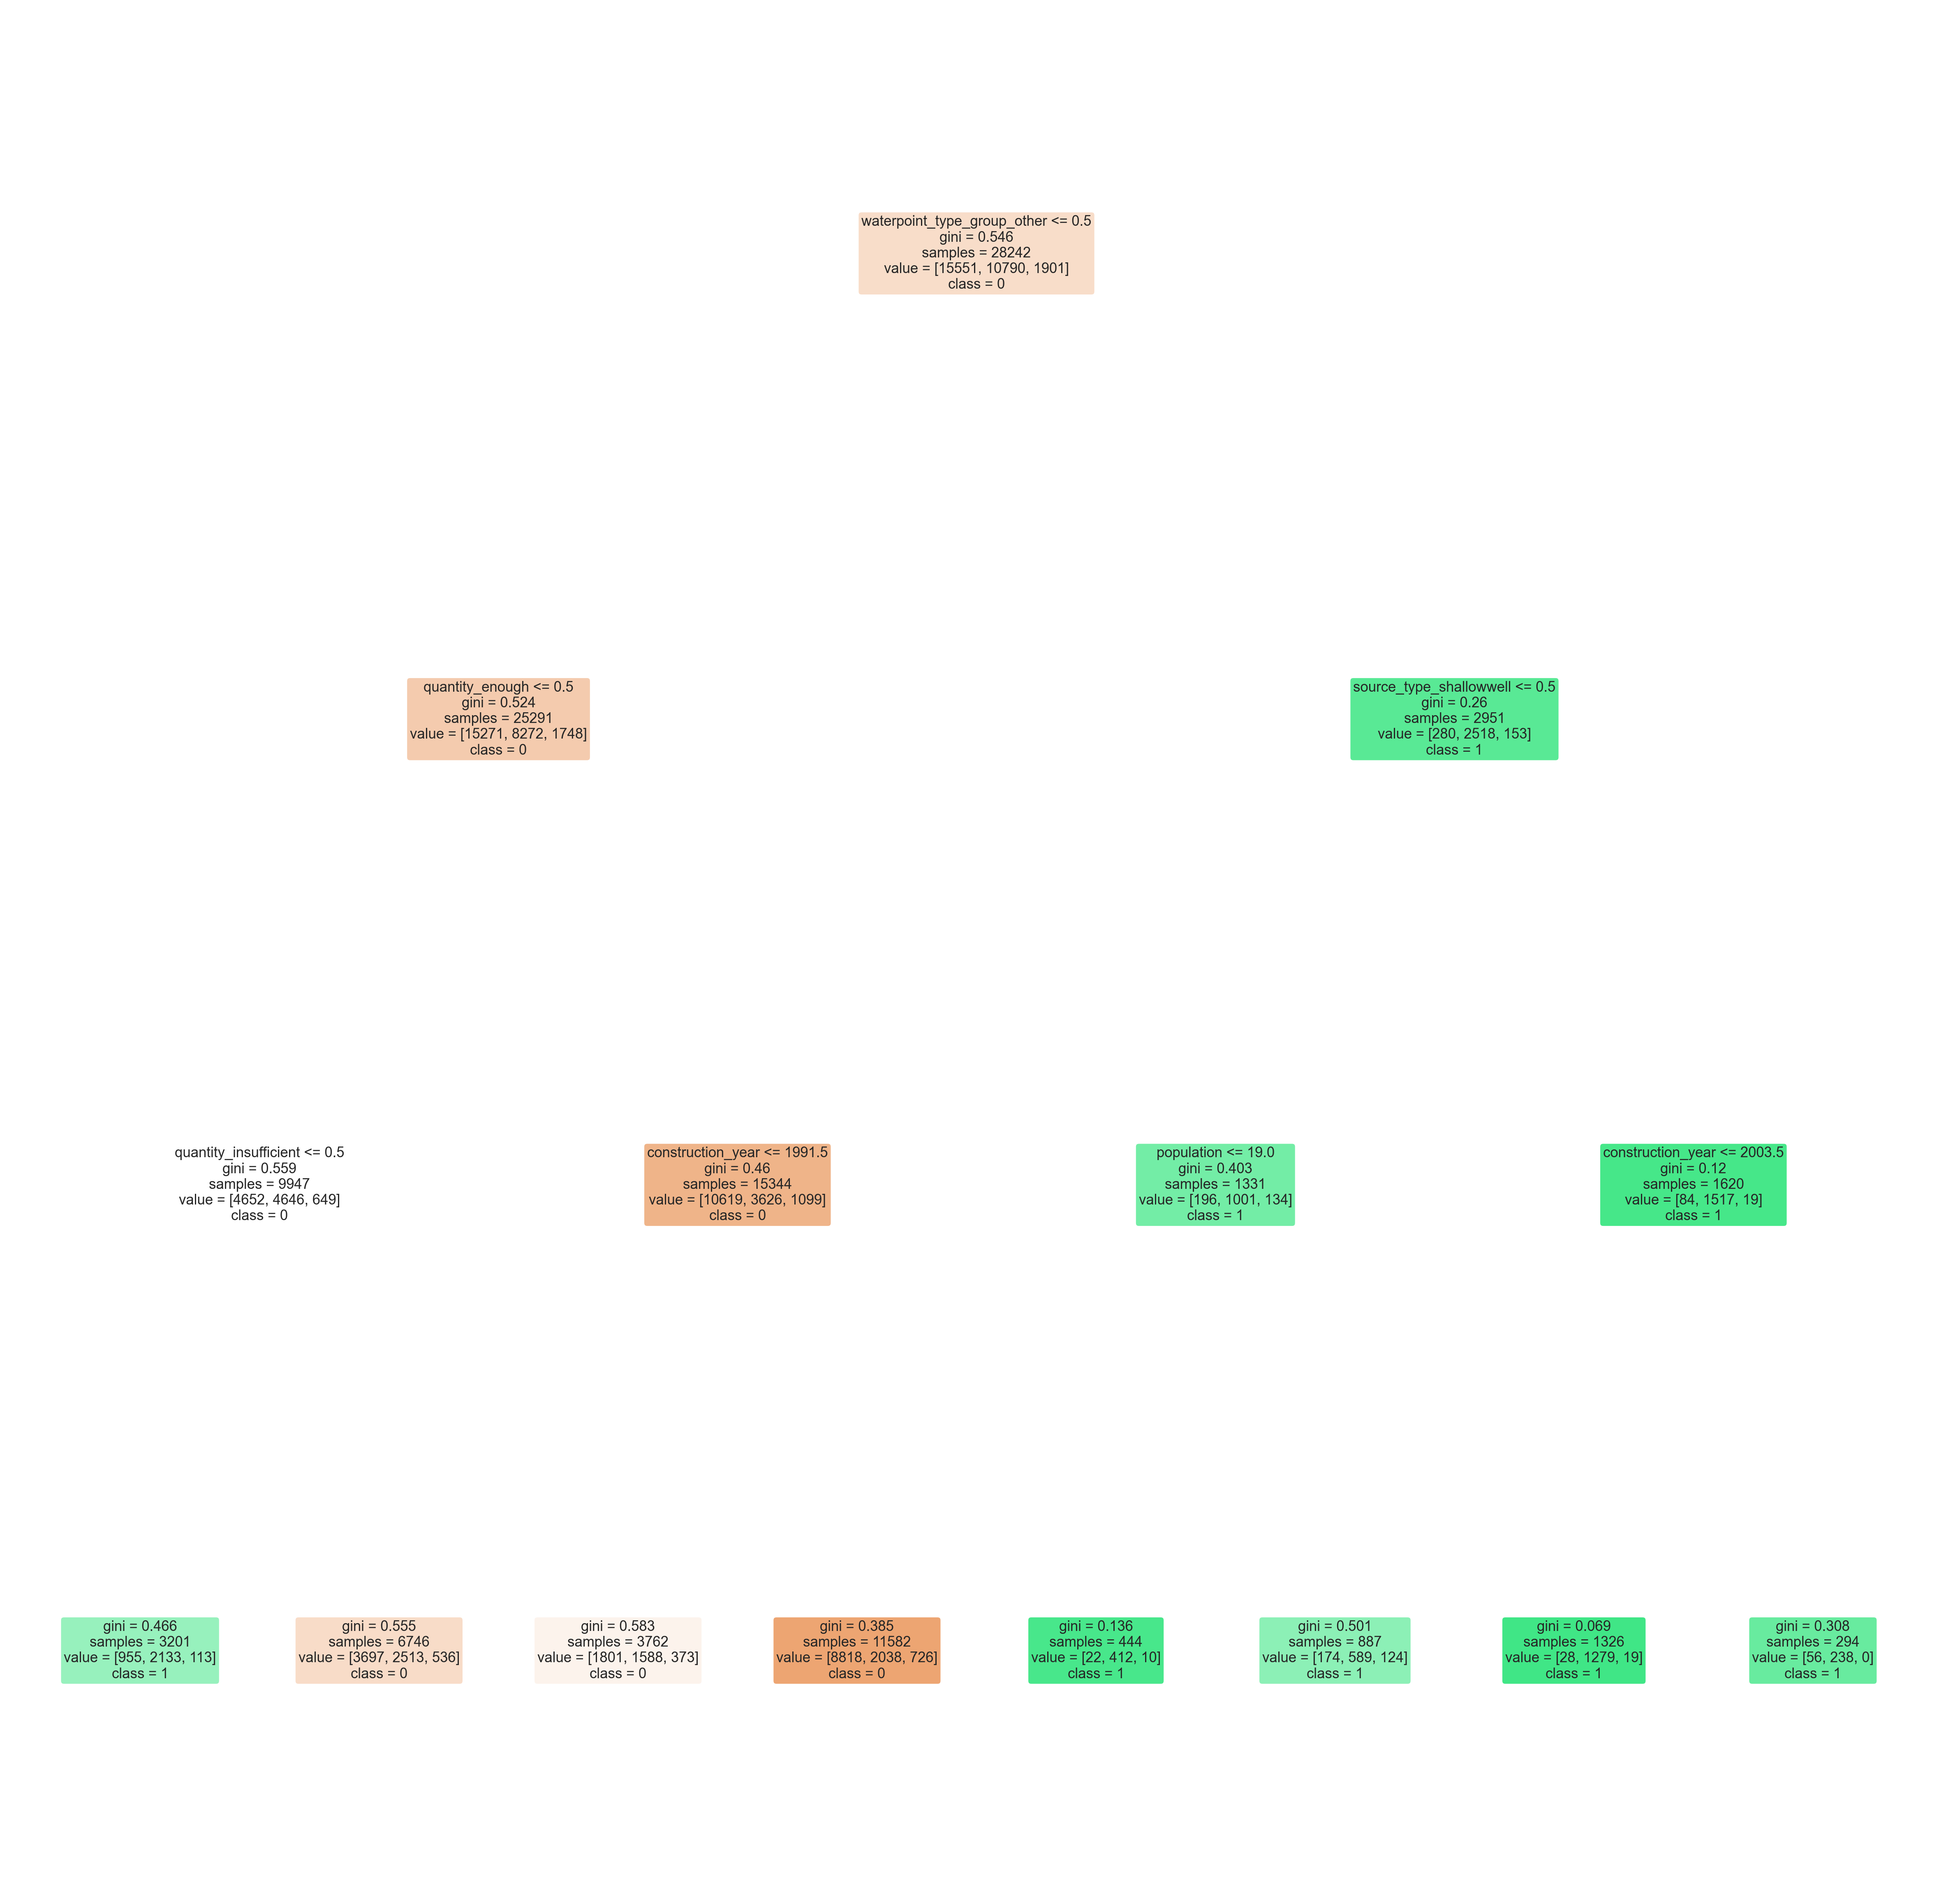

In [121]:
# Plot and show decision tree
plt.figure(figsize=(12,12), dpi=500)
tree.plot_tree(ctree, 
               feature_names=X.columns,
               class_names=np.unique(y).astype('str'),
               filled=True, rounded=True)
plt.show()

## Mod√®le 4 ‚Äì KNN (K-Nearest Neighbors)

**Pourquoi KNN ?**
- Le mod√®le KNN est simple et interpr√©table.
- Il repose sur la similarit√© entre les points : un √©chantillon est class√© selon la majorit√© des classes de ses voisins les plus proches.

**Important :** KNN est tr√®s sensible √† l‚Äô√©chelle des donn√©es, d‚Äôo√π la n√©cessit√© de normaliser.

In [122]:
from sklearn.preprocessing import StandardScaler

In [123]:
# Normalisation des donn√©es
scaler = StandardScaler()
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

In [124]:
scaled_df_train = pd.DataFrame(scaled_train, columns=X.columns)
scaled_df_train.head()

amount_tsh  gps_height  longitude  latitude  population    permit  \
0   -0.363222    1.803868  -0.215814  1.570144   -0.102383 -1.585421   
1    0.423960   -0.217388  -2.393290  0.518166   -0.076915  0.630747   
2    0.292763    0.917638  -0.588754 -0.976372   -0.458930  0.630747   
3   -0.350103    1.018457  -0.224588  0.625247    0.157388  0.630747   
4    6.196632    1.685162  -0.557372 -1.068247   -0.527693  0.630747   

   construction_year  basin_LakeNyasa  basin_LakeRukwa  basin_LakeTanganyika  \
0           1.134051        -0.230857        -0.169197             -0.336002   
1           0.973242        -0.230857        -0.169197              2.976171   
2          -1.519292        -0.230857        -0.169197             -0.336002   
3           0.973242        -0.230857        -0.169197             -0.336002   
4           0.973242        -0.230857        -0.169197             -0.336002   

   ...  extraction_type_class_motorpump  extraction_type_class_other  \
0  ...                        -0.190997                    -0.331415   
1  ...                        -0.190997                    -0.331415   
2  ...                        -0.190997                    -0.331415   
3  ...                        -0.190997                    -0.331415   
4  ...                        -0.190997                    -0.331415   

   extraction_type_class_ropepump  extraction_type_class_submersible  \
0                       -0.089815                          -0.388462   
1                       -0.089815                          -0.388462   
2                       -0.089815                          -0.388462   
3                       -0.089815                          -0.388462   
4                       -0.089815                          -0.388462   

   extraction_type_class_wind_powered  \
0                           -0.039949   
1                           -0.039949   
2                           -0.039949   
3                           -0.039949   
4                           -0.039949   

   waterpoint_type_group_communalstandpipe  waterpoint_type_group_dam  \
0                                 0.724418                  -0.011902   
1                                 0.724418                  -0.011902   
2                                 0.724418                  -0.011902   
3                                 0.724418                  -0.011902   
4                                 0.724418                  -0.011902   

   waterpoint_type_group_handpump  waterpoint_type_group_improvedspring  \
0                       -0.542401                             -0.103092   
1                       -0.542401                             -0.103092   
2                       -0.542401                             -0.103092   
3                       -0.542401                             -0.103092   
4                       -0.542401                             -0.103092   

   waterpoint_type_group_other  
0                    -0.341587  
1                    -0.341587  
2                    -0.341587  
3                    -0.341587  
4                    -0.341587  

[5 rows x 74 columns]

In [132]:
from sklearn.neighbors import KNeighborsClassifier

In [133]:
# Entra√Ænement du mod√®le KNN
clfK = KNeighborsClassifier()

clfK.fit(scaled_df_train, y_train)

KNeighborsClassifier()

In [134]:
# Make predictions for test data
# y_pred = clfK.predict(scaled_test)

# Predict on training and test sets
training_preds = clfK.predict(scaled_df_train)
test_preds = clfK.predict(scaled_test)

In [137]:
# Get results
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Test Accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 82.99%
Test Accuracy: 76.97%


In [138]:
print(classification_report(y_train, training_preds))
print(pd.crosstab(y_train, training_preds, rownames=['True'], colnames=['Predicted'], margins=True))
print(classification_report(y_test, test_preds))
print(pd.crosstab(y_test, test_preds, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       0.82      0.91      0.87     15551
           1       0.85      0.80      0.82     10790
           2       0.70      0.33      0.45      1901

    accuracy                           0.83     28242
   macro avg       0.79      0.68      0.71     28242
weighted avg       0.83      0.83      0.82     28242

Predicted      0      1    2    All
True                               
0          14181   1174  196  15551
1           2094   8621   75  10790
2            951    315  635   1901
All        17226  10110  906  28242
              precision    recall  f1-score   support

           0       0.77      0.86      0.81      3888
           1       0.78      0.73      0.76      2698
           2       0.54      0.23      0.32       475

    accuracy                           0.77      7061
   macro avg       0.70      0.61      0.63      7061
weighted avg       0.76      0.77      0.76      7061

Predicted     0     1 

## Rapport - KNN (K-Nearest Neighbors)

Le mod√®le KNN normalis√© obtient **82,99% de pr√©cision sur l‚Äôentra√Ænement** et **76,97% sur le test**, montrant un l√©ger surapprentissage mais des performances globales correctes. Il d√©tecte tr√®s bien les puits fonctionnels (classe 0), identifie assez bien les puits r√©parables (classe 1), mais a des difficult√©s √† pr√©dire les puits non fonctionnels (classe 2), qui sont souvent mal class√©s. Ces r√©sultats sugg√®rent que KNN est efficace pour les classes majoritaires mais moins pour les classes minoritaires, et que l‚Äôutilisation d‚Äôun r√©√©quilibrage des classes (SMOTE) ou de mod√®les plus robustes (Random Forest, XGBoost) pourrait am√©liorer la d√©tection des puits cass√©s.
